# Add thread level data

- The resulting dataset that we should use for modeling going forward is `Data/working_dataset_v2.pkl`
- 29% of values of `parent_score` are missing. Slightly more (another 3.23%) for `parent_cos_angle` and `title_cos_angle` because a few comments could not be embedded

### Load Libraries

In [1]:
import re
import string

import feather
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read in Benchmark Data and Thread Data

In [2]:
processed_data = pd.read_pickle('Data/working_dataset_v1.pkl')
f"{processed_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.070396228881056 GB'

In [3]:
scraped_data = pd.read_pickle('Data/scrape/df_final.pkl')
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.03810666985135063 GB'

### Original Features

- `created_utc`: the time (in seconds) when the comment was posted 
- `ups`: number of upvotes on the comment
- `subreddit_id`: id of the specific subreddit
- `link_id`: id of the particular comment thread
- `name`: name of the comment
- `score_hidden`: 1 if the score of the comment was hidden; 0 else
- `author_flair_css_class`: CSS class for the comment flair
- `author_flair_text`: flair text for the comment
- `id`: id of the comment (basically the same as comment name)
- `removal_reason`: reason a comment was removed (either `legal` or `None`)
- `gilded`: the number of gilded tags (~ premium likes) on the comment 
- `downs`: number of downvotes on the comment
- `archived`: if the thread was archived (no new comments, no new likes) 
- `author`: author's reddit username
- `score`: number of upvotes
- `retrieved_on`: The time (in seconds) when the comment was pulled to create the dataset. 
- `body`: the comment itself
- `distinguished`: the type of user on the page. Either `moderator`, `admin`, or `None`. 
- `edited`: whether (1) or not (0) the comment has been edited
- `controversiality`: a Boolean indicating whether (1) or not (0) a comment is controversial -- i.e., popular comments that are getting closely the same amount of upvotes as downvotes. 
- `parent_id`: the id of the comment that this comment was replying to. `None` if the comment is not a reply

In [4]:
# processed_data.head().T

In [5]:
scraped_data.head().T

,0,1,2,3,4
sub_id,t3_34gagr,t3_34gnav,t3_34fsr0,t3_34erib,t3_34gkc7
created_utc,1.43043e+09,1.43044e+09,1.43042e+09,1.43041e+09,1.43044e+09
distinguished,None,None,None,None,None
edited,False,False,False,False,False
locked,False,False,False,False,False
url,http://www.washingtonpost.com/blogs/wonkblog/w...,http://i.imgur.com/iOF4sI6.jpg,http://i.imgur.com/QN6RLSH.jpg,http://i.imgur.com/gODPprxl.jpg,http://i.imgur.com/2iU1r69.jpg
num_comments,23,3,15,26,14
over_18,False,False,False,False,False
score,131,4,98,220,12
selftext,,,,,


In [6]:
scraped_data['url'] = scraped_data.url.astype('category')
scraped_data['selftext'] = scraped_data.selftext.astype('category')
scraped_data['title'] = scraped_data.title.astype('category')

In [7]:
scraped_data['link_created_time'] = pd.to_datetime(scraped_data.created_utc, unit='s')

In [8]:
scraped_data.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [9]:
scraped_data.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [10]:
scraped_data.tail().T

,45395,45396,45397,45398,45399
link_id,t3_380j06,t3_380k50,t3_380ld3,t3_380lty,t3_380msc
url,https://www.yahoo.com/news/us-demands-immediat...,http://www.irishtimes.com/news/world/middle-ea...,http://www.timesofisrael.com/israels-army-skir...,http://time.com/3902702/us-college-student-isi...,http://www.healthy4u.net/2015/05/30/easy-diet-...
num_comments,10,1,6,5,1
over_18,False,False,False,False,False
link_score,9,9,0,8,1
selftext,,,,,
title,"US hits out at China over sea reclamation, vow...",Israel moves to toughen sentences for stone-th...,Israel's Army operating program to convert Jew...,Hero Student Tries to Stop ISIS Attack in Saud...,easy diet
upvote_ratio,0.62,0.84,0.38,0.68,1
link_ups,9,9,0,8,1
link_created_time,2015-05-31 23:19:50,2015-05-31 23:29:11,2015-05-31 23:38:41,2015-05-31 23:42:18,2015-05-31 23:50:20


In [11]:
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.028195456273879205 GB'

In [12]:
df = processed_data.merge(scraped_data, on='link_id', how='left')
# for some reason the join doesn't work
# df = df.join(other=dfl, on='link_id', how='outer')

In [13]:
df['time_since_link'] = (df.time - df.link_created_time)
df.time_since_link = [x.total_seconds() for x in df.time_since_link]

In [14]:
df.shape

(1238616, 51)

In [15]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'1.3856231218233332 GB'

In [16]:
df.head(3).T

,0,1,2
created_utc,1430438556,1430438571,1430438572
ups,4,2,2
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34dogt,t3_34drd4
name,t1_cqugc7x,t1_cqugcj4,t1_cqugcjl
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,food,food,food
gilded,0,0,0


In [17]:
# drops about 2000 rows due to link_id not in scraped_data
df = df.iloc[np.where(df.title == df.title)]
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(1236322, 51)


'1.3830168261283544 GB'

## Engineer new features

In [18]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
df['url'] = df.url.astype('category')
df['is_root'] = df.parent_id.str.startswith('t3_')
df['is_selftext'] = df.selftext.str.len() > 1

In [19]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

num_partitions = 100
num_cores = 6
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)
    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.twitter.27B.200d.txt')
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')
comment_to_title = pd_to_dict(df[['name', 'title']],
                                index='name', column='title')

def get_cosine_angle_parent(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return np.nan
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return np.nan
    if parent is None:
        return np.nan
    return cosine(child, parent)

def wrapper_get_cosine_parent(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle_parent)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine_parent)
df['parent_cos_angle'] = cosine_angle.cosine_angle
del cosine_angle

def get_cosine_angle_title(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_title[cmnt_id]
        child = get_doc2vec(child, gloves)
        parent = get_doc2vec(parent, gloves)
    except:
        return None
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent)

def wrapper_get_cosine_title(df):
    df['cosine_angle2'] = df['name'].apply(get_cosine_angle_title)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine_title)
df['title_cos_angle'] = cosine_angle.cosine_angle2

del cosine_angle
del comment_to_body
del comment_to_parent
del gloves

In [20]:
# df.head(20).T

In [21]:
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(1236322, 55)


'1.3954487197915035 GB'

In [22]:
print(sum(df.parent_cos_angle != df.parent_cos_angle) / len(df.parent_cos_angle)) # pct NaN
print(sum(df.parent_cos_angle == 0) / len(df.parent_cos_angle)) # pct zero

0.33786343687162407
0.0009002509055084355


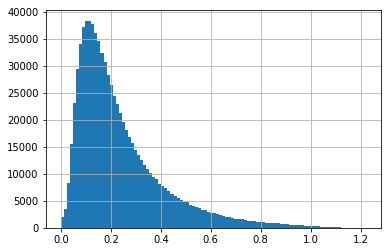

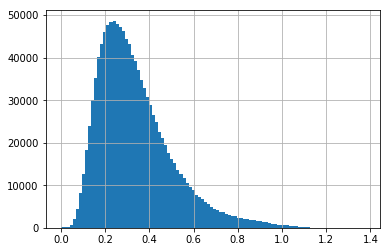

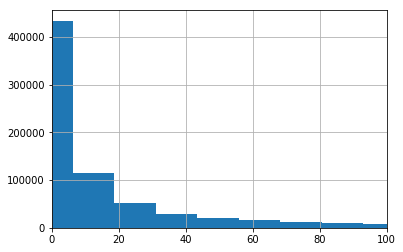

In [23]:
df.parent_cos_angle.hist(bins=100)
plt.show()
df.title_cos_angle.hist(bins=100)
plt.show()
df.parent_score.hist(bins=500)
plt.xlim([0,100])
plt.show()

In [24]:
print(df.shape)
df.to_pickle('Data/working_dataset_v2.pkl')

(1236322, 55)


In [25]:
df = pd.read_pickle('Data/working_dataset_v2.pkl')
print(f"{processed_data.memory_usage(deep=True).sum() / 1023.0**3} GB")
df.head().T

1.079374396711071 GB


,0,2,3,5,6
created_utc,1430438556,1430438572,1430438641,1430438762,1430438833
ups,4,2,1,2,0
subreddit_id,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55,t5_2qh55
link_id,t3_34gagr,t3_34drd4,t3_34drd4,t3_34gkc7,t3_34fsr0
name,t1_cqugc7x,t1_cqugcjl,t1_cqugdz8,t1_cquggkz,t1_cqugi3n
score_hidden,0,0,0,0,0
author_flair_css_class,None,None,None,None,None
author_flair_text,None,None,None,None,None
subreddit,food,food,food,food,food
gilded,0,0,0,0,0
